Отберите из тренировочного набора данных (файл train.zip) изображения с именами в диапазоне [cat.10150.jpg, cat.10250.jpg) и [dog.10150.jpg, dog.10250.jpg). Всего должно получиться по  изображений кошек и собак. Эти данные будут тестовыми.
Произведите оценку модели на отобранных тестовых данных:

Имя файла: cat.10242.jpg. Введите вероятность отнесения объекта классу cats:

Имя файла: dog.10242.jpg. Введите вероятность отнесения объекта классу dogs:

In [ ]:
!pip install -q tensorflow
!pip install -q keras

In [28]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import plot_model
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import os, random, shutil
from PIL import ImageFile
import zipfile
ImageFile.LOAD_TRUNCATED_IMAGES = True


if not os.path.exists('/content/sample_data/test/train/cats/'):
  os.makedirs('/content/sample_data/test/train/cats/')
if not os.path.exists('/content/sample_data/test/train/dogs/'):
  os.makedirs('/content/sample_data/test/train/dogs/')
if not os.path.exists('/content/sample_data/test/preview/'):
  os.makedirs('/content/sample_data/test/preview/')
if not os.path.exists('/content/sample_data/test/validation/cats'):
  os.makedirs('/content/sample_data/test/validation/cats')
if not os.path.exists('/content/sample_data/test/validation/dogs'):
  os.makedirs('/content/sample_data/test/validation/dogs')

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Данные для доступа API
api_token = {"username":"","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

mkdir: cannot create directory ‘/root/.kaggle’: File exists
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
with zipfile.ZipFile("dogs-vs-cats.zip", 'r') as zip_ref:
  zip_ref.extractall(".")

In [ ]:
shutil.move("/content/test1.zip", "/content/sample_data/")
shutil.move("/content/train.zip", "/content/sample_data/")

In [ ]:
with zipfile.ZipFile("Model_10k_images_cats_dogs_trained.zip", 'r') as z:
  z.extractall(".")

In [ ]:
from keras.models import model_from_json
from keras import backend as K
# Load model architecture from JSON file
json_file = open('model_10k.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# Load weights into the new model
model.load_weights("Model_10k_images.h5")
print("Loaded model from disk")

# Compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Image dimensions
img_width, img_height = 150, 150
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Loaded model from disk


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                   

In [18]:
if not os.path.exists('test_dataset/test/cats/'):
  os.makedirs('test_dataset/test/cats/')
if not os.path.exists('test_dataset/test/dogs/'):
  os.makedirs('test_dataset/test/dogs/')
extract_folder = 'test_dataset'
zip_file = "sample_data/train.zip"
os.makedirs(extract_folder, exist_ok=True)
startswith_cats = "cat" # начало имени файла для кошек
startswith_dogs = "dog" # начало имени файла для собак
with zipfile.ZipFile(zip_file, 'r') as z:
  for f in z.namelist():
    file_new = f.rsplit( "/", 1 )[ 1 ]
    if startswith_cats in f and 10150 <= int(f.split('.')[1]) < 10250:
      z.extract(f, "test_dataset")
      os.replace('test_dataset/train/'+file_new, 'test_dataset/test/cats/'+file_new)
    elif startswith_dogs in f and 10150 <= int(f.split('.')[1]) < 10250:
      z.extract(f, "test_dataset")
      os.replace('test_dataset/train/'+file_new, 'test_dataset/test/dogs/'+file_new)

In [19]:
test_dir = 'test_dataset/test/'
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=200,
    class_mode='binary',
    shuffle=False)
imgs,labels=test_generator.next()
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model.predict(imgs)
rounded_pred=np.asarray([np.round(i) for i in predictions])

Found 200 images belonging to 2 classes.
7/7 [==============================] - 3s 353ms/step


In [20]:
list=[item for item in zip(array_imgs, rounded_pred, labels, predictions) if item[1]!=item[2]] # список изображений, для которых предсказание не совпало с реальностью
print("Ошибочных:",len(list))

Ошибочных: 45


In [21]:
from sklearn.metrics import precision_score, f1_score, accuracy_score
precision = precision_score(labels, rounded_pred, average='macro')
f1 = f1_score(labels, rounded_pred, average='macro')
accuracy = accuracy_score(labels, rounded_pred)

# Print metrics
print(f"Precision (Macro Avg): {precision}")
print(f"F1-Score (Macro Avg): {f1}")
print(f"Accuracy: {accuracy}")

Precision (Macro Avg): 0.7831840181237772
F1-Score (Macro Avg): 0.7733625443831684
Accuracy: 0.775


In [22]:
accuracy = model.evaluate_generator(test_generator,1)
print(f"Accuracy: {accuracy}")

<ipython-input-22-700eda97df25>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy = model.evaluate_generator(test_generator,1)


Accuracy: [0.43836265802383423, 0.7749999761581421]


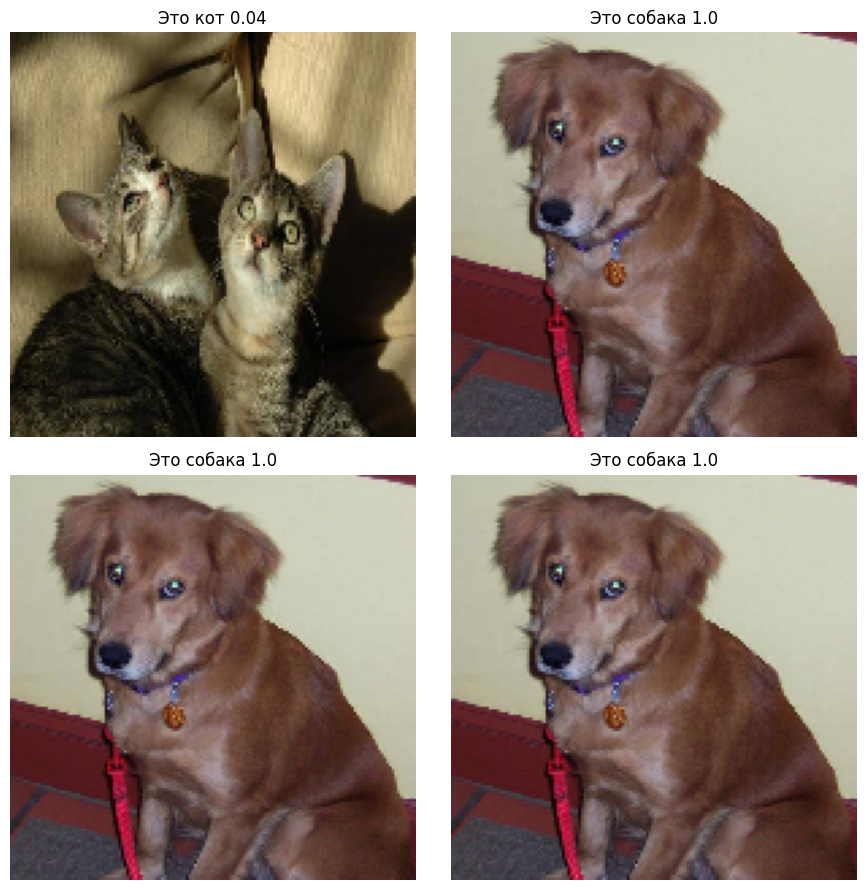

In [23]:
list1 = [item for item in zip(array_imgs, rounded_pred, labels, predictions)]
fig = plt.figure(figsize=(9,9))
# выведем результат для 4-х любых изображений
items = [list1[92],list1[92], list1[192], list1[192], list1[192]]
for i in range(1,5):
    item = items[i]
    img = item[0]
    ax = fig.add_subplot(2, 2, i)
    plt.axis('off')
    ax.imshow(np.transpose(img,(1,0,2)))
    if np.round(item[3][0], 2) <= 0.5:
      ax.set_title('%s %s' % ('Это кот',np.round(item[3][0], 2)), fontsize=12)
    else:
      ax.set_title('%s %s' % ('Это собака',np.round(item[3][0])), fontsize=12)
fig.tight_layout()
plt.show()

In [26]:
1-items[1][3][0]

0.9566821679472923

In [25]:
items[2][3][0]

0.96516335